# Case Study

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import statistics
import scipy.stats as stats
import matplotlib.dates as mdates
from scipy.stats import norm

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")

In [2]:
def import_data(link):
  """ Imports the data from a certain url link

    Args:
        link (str): url to the data

    """
  with urllib.request.urlopen(link) as response:
      data = response.read().decode('utf-8')

  data = data.split("\n")
  data_list = []

  for row in data[2:-1]:
      row_list = list(filter(None, row.split(' ')))
      row_list[1] = row_list[1].rstrip('\r')
      data_list.append({'Date': row_list[0], 'Value': row_list[1]})

  df = pd.DataFrame(data_list)
  df['Date'] = pd.to_datetime(df['Date'])
  df['Value'] = df['Value'].astype(float)
  return df

In [3]:
df = import_data('https://hadleyserver.metoffice.gov.uk/hadcet/data/meantemp_daily_totals.txt')

In [4]:
def delete_leap_year(df):
  """ Deletes leap years from the data frame

    Args:
        df (pd.DataFrame): data frame with leap years

    Returns:
        pd.DataFrame: df without the day 02-29

    """
  df['Day'] = df['Date'].dt.day
  df['Month'] = df['Date'].dt.month
  df = df[~((df['Month'] == 2) & (df['Day'] == 29))]
  df.drop(columns=['Day', 'Month'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df

In [5]:
df = delete_leap_year(df)
for i in df['Date']:
    if '-02-29' in str(i):
        print(i)

### H matrix

In [6]:
def fill_matrix(df, year, day, w):
    """ Fill the matrix with ones for a specic day in a year given a certain window

    Args:
        df (pd.DataFrame): contains the matrix with zeros and ones
        year (int): the year for for which we want to fill the days with ones
        day (str): the day around we want to fill the days with ones
        w (int): the window indicates how many days we want to fill with ones
    """

    day_ind = df.columns.get_loc(day)

    # Loop throught the window
    for i in range(0, int(w/2)):
        ind_bef = day_ind - i
        ind_aft = day_ind + i

        # Handle if days exceeds year
        if ind_aft >= len(df.columns):
            year_aft = year + 1
            df.loc[year_aft, df.columns[ind_aft - len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_aft < len(df.columns):
          df.loc[year, df.columns[ind_aft]] = 1


        # Handle if days deceeds year
        if ind_bef < 0:
            year_bef = year - 1
            df.loc[year_bef, df.columns[ind_bef + len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_bef >= 0:
          df.loc[year, df.columns[ind_bef]] = 1


In [7]:
def get_matrix(first_year, last_year, day):
    """ Create a matrix containing zeros and ones for a specific block around a
    day within certain years

    Args:
        first_year (str): the first year for which we want to create a window of
        ones
        last_year (str): the last year for which we want to create a window of
        ones
        day (str): the day around we want to fill the days with ones

    Returns:
        pd.DataFrame: df containing zeros and ones for a specific date (note
        that the df contains an extra year before and after the last year)

    """

    # Create a list containing all days of a non-leap year
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

    # Make a df with days as columns and years 1979-2021 as rows
    df = pd.DataFrame(0, index=range(first_year-1, last_year+2), columns=[f'{date.day}-{date.month}' for date in days_in_year])

    # Define window
    w = 30

    # Loop through the years and fill matrix with 1 ones around a specific date given a window w
    for year in range(first_year, last_year + 1):
        fill_matrix(df, year, day,w)

    return df

In [8]:
def get_subset_df(df, first_year, last_year):
    """ Create a subset of a dataframe given certain years

    Args:
        first_year (str): the first year included in the subset
        last_year (str): the last year included in the subset
        df (pd.DataFrame): df from which we want the subset

    Returns:
        pd.DataFrame: df containing the subset

    """

    subset = df[(df['Date'] >= str(first_year)) & (df['Date'] < str(last_year+1))]

    chunk_size = 365
    chunks = [subset[i:i+chunk_size] for i in range(0, len(subset), chunk_size)]

    df_subset = pd.DataFrame()

    for year in range(0,(last_year-first_year+1)):
        value_series = chunks[year]['Value'].reset_index(drop=True)
        columns = []

        for day in range(0, 365):
            value_for_day = value_series[day]
            column_series = pd.Series(value_for_day)
            columns.append(column_series)

        df_1_year = pd.concat(columns, axis=1)
        df_subset = pd.concat([df_subset, df_1_year], ignore_index=True)

    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    df_subset.columns = [f'{date.day}-{date.month}' for date in days_in_year]
    df_subset.index = range(first_year, last_year+1)
    return df_subset

# Refactored Phi
Dit is die snelle snelle code maat

In [18]:
def get_h_min1(h):
    shifted_h = np.roll(h, 1)
    
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    
    h_min1 = pd.DataFrame(shifted_h, columns=[f'{date.day}-{date.month}' for date in days_in_year])

    return h_min1

In [19]:
first_year = 1980
last_year = 2020

df_subset = get_subset_df(df,first_year-1, last_year+1)

phi_list = []
ci_upper_list = []
ci_lower_list = []

for date in pd.date_range(start='1/1/2023', end='12/31/2023', freq='D'):
    h = get_matrix(first_year, last_year, f'{date.day}-{date.month}')
    y = df_subset.values * h.values
    y_bar = sum(y) / sum(h.values)
    y_tilde = (y - y_bar*h).fillna(0)
    
    h_min1 = get_h_min1(h)
    y_min1 = np.roll(y, 1)
    y_bar_min1 = sum(y_min1) / sum(h_min1.values)
    y_min1_tilde = (y_min1 - y_bar_min1*h_min1).fillna(0)
    
    numerator = y_tilde.values*y_min1_tilde.values
    denominator = y_min1_tilde.values**2*h.values*h_min1.values
    
    phi_hat = numerator.sum() / denominator.sum()
    phi_list.append(phi_hat)

    z_critical = norm.ppf(1 - 0.05 / 2)
    margin_of_error = np.sqrt((1-phi_hat**2)/(h.values*h_min1.values).sum())*z_critical
    
    ci_upper = phi_hat + margin_of_error
    ci_lower = phi_hat - margin_of_error
    ci_upper_list.append(ci_upper)
    ci_lower_list.append(ci_lower)

    print(f'Finished computing date: {date.day}-{date.month}', end='\r')


C:\Users\tcornew\AppData\Local\Temp\ipykernel_17360\3491242124.py:13: RuntimeWarning: invalid value encountered in divide
  y_bar = sum(y) / sum(h.values)
C:\Users\tcornew\AppData\Local\Temp\ipykernel_17360\3491242124.py:18: RuntimeWarning: invalid value encountered in divide
  y_bar_min1 = sum(y_min1) / sum(h_min1.values)


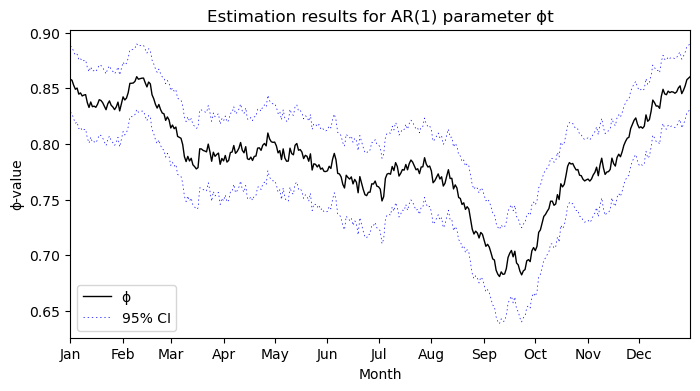

In [20]:
days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

phi_df = pd.DataFrame()
phi_df['Date'] = days_in_year
phi_df['Mean'] = phi_list
phi_df['CI lower'] = ci_lower_list
phi_df['CI upper'] = ci_upper_list

plt.figure(figsize=(8, 4))
plt.plot(phi_df['Date'], phi_df['Mean'], label='ϕ', linestyle='-', color='black', linewidth=1)
plt.plot(phi_df['Date'], phi_df['CI upper'], linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
plt.plot(phi_df['Date'], phi_df['CI lower'], linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim(phi_df['Date'].min(), phi_df['Date'].max())
plt.title('Estimation results for AR(1) parameter ϕt')
plt.xlabel('Month')
plt.ylabel('ϕ-value')
# plt.ylim(0.65,0.9)
plt.legend()
plt.show()